In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
from matplotlib.ticker import ScalarFormatter
import mplfinance as mpf

In [2]:
df_raw = pd.read_csv('DailyDelhiClimateTrain.csv')
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw.set_index('date', inplace=True)
df_raw.shape

(1462, 4)

In [3]:
df_raw.head(5)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
def create_sliding_window(df, target_col, window_size):
    df_windows = []
    index_list = [] 
    
    for i in range(window_size, len(df)):
        features = df.iloc[i - window_size:i].values.flatten()
        target = df.iloc[i][target_col]
        df_windows.append(np.append(features, target))
        
        index_list.append(df.index[i])

    feature_columns = [f"{col}_t-{j}" for j in range(window_size, 0, -1) for col in df.columns]
    df_sliding = pd.DataFrame(df_windows, columns=feature_columns + [target_col], index=index_list)

    return df_sliding



def split_and_scale_data(df, target_col, scaler, window_size, test_size=0.2):
    df_sliding = create_sliding_window(df, target_col, window_size)
    X = df_sliding.drop(columns=[target_col])
    y = df_sliding[target_col]

    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    x_scaler = scaler
    X_train_scaled = x_scaler.fit_transform(X_train)
    X_test_scaled = x_scaler.transform(X_test)

    y_scaler = scaler
    y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
    y_test_scale = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scale, y_train, y_test, x_scaler, y_scaler


def evaluate_linear_model(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, y_train, y_test, y_scaler):
    model = LinearRegression().fit(X_train_scaled, y_train_scaled)

    train_pred_scaled = model.predict(X_train_scaled).reshape(-1, 1)
    test_pred_scaled = model.predict(X_test_scaled).reshape(-1, 1)

    train_pred = y_scaler.inverse_transform(train_pred_scaled).ravel()
    test_pred = y_scaler.inverse_transform(test_pred_scaled).ravel()

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
    mape = lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100

    results = {
        'train': {
            'MAE': mean_absolute_error(y_train, train_pred),
            'RMSE': rmse(y_train, train_pred),
            'MAPE': mape(y_train, train_pred)
        },
        'test': {
            'MAE': mean_absolute_error(y_test, test_pred),
            'RMSE': rmse(y_test, test_pred),
            'MAPE': mape(y_test, test_pred)
        }
    }

    return model, results, y_test, test_pred

def evaluate_random_forest_model(
    X_train_scaled, X_test_scaled,
    y_train_scaled, y_test_scaled,
    y_train, y_test,
    y_scaler,
    n_estimators,
    max_depth,
    min_samples_leaf
):
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(X_train_scaled, y_train_scaled)

    train_pred_scaled = model.predict(X_train_scaled).reshape(-1, 1)
    test_pred_scaled = model.predict(X_test_scaled).reshape(-1, 1)

    train_pred = y_scaler.inverse_transform(train_pred_scaled).ravel()
    test_pred = y_scaler.inverse_transform(test_pred_scaled).ravel()

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
    mape = lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100

    results = {
        'train': {
            'MAE': mean_absolute_error(y_train, train_pred),
            'RMSE': rmse(y_train, train_pred),
            'MAPE': mape(y_train, train_pred)
        },
        'test': {
            'MAE': mean_absolute_error(y_test, test_pred),
            'RMSE': rmse(y_test, test_pred),
            'MAPE': mape(y_test, test_pred)
        }
    }

    return model, results, y_test, test_pred


def evaluate_XGB_model(
    X_train_scaled, X_test_scaled,
    y_train_scaled, y_test_scaled,
    y_train, y_test,
    y_scaler,
    max_depth,
    reg_lambda,
    learning_rate,
    n_estimators,
    reg_alpha
):
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        reg_lambda=reg_lambda,
        learning_rate=learning_rate,
        reg_alpha=reg_alpha,
        random_state=42)
    model.fit(X_train_scaled, y_train_scaled)

    train_pred_scaled = model.predict(X_train_scaled).reshape(-1, 1)
    test_pred_scaled = model.predict(X_test_scaled).reshape(-1, 1)

    train_pred = y_scaler.inverse_transform(train_pred_scaled).ravel()
    test_pred = y_scaler.inverse_transform(test_pred_scaled).ravel()

    rmse = lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred))
    mape = lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100

    results = {
        'train': {
            'MAE': mean_absolute_error(y_train, train_pred),
            'RMSE': rmse(y_train, train_pred),
            'MAPE': mape(y_train, train_pred)
        },
        'test': {
            'MAE': mean_absolute_error(y_test, test_pred),
            'RMSE': rmse(y_test, test_pred),
            'MAPE': mape(y_test, test_pred)
        }
    }

    return model, results, y_test, test_pred

def run_exp(df_input, ft_cols, target_col, scaler):
    list_sliding = [3,7,14,30]

    best_linear = {
        'window_size': None,
        'result': None,
        'model': None,
        'x_scaler': None,
        'y_scaler': None,
        'real_target_values': None,
        'predicted_values': None
    }

    list_max_depth = [2, 3, 5, 10]
    list_n_estimators = [50, 100, 150, 200]
    list_min_samples_leaf = [1, 3, 5, 10]

    best_rf = {
        'window_size': None,
        'result': None,
        'model': None,
        'x_scaler': None,
        'y_scaler': None,
        'real_target_values': None,
        'predicted_values': None
    }

    list_max_depth_xgb = [ 6, 7, 8]
    list_lambda = [0.5, 1, 2]
    list_learning_rate = [0.05, 0.1, 0.5]
    list_n_estimators_xgb  = [100, 150, 200]
    list_alpha = [0.5, 1]

    best_xgb = {
        'window_size': None,
        'result': None,
        'model': None,
        'x_scaler': None,
        'y_scaler': None,
        'real_target_values': None,
        'predicted_values': None
    }

    for t in list_sliding:
        print(f" --------- window size: {t}")

        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scale, y_train, y_test, x_scaler, y_scaler = split_and_scale_data(df_input[ft_cols].copy(), target_col, scaler, t)

        model, scores, y_test_inv, test_pred_inv = evaluate_linear_model(X_train_scaled, X_test_scaled, y_train_scaled, y_test_scale, y_train, y_test, y_scaler)

        if best_linear['window_size'] is None or scores['test']['RMSE'] < best_linear['result']['test']['RMSE']:
            best_linear['window_size'] = t
            best_linear['result'] = scores
            best_linear['model'] = model
            best_linear['x_scaler'] = x_scaler
            best_linear['y_scaler'] = y_scaler
            best_linear['real_target_values'] = y_test_inv
            best_linear['predicted_values'] = test_pred_inv

        for n_estimators, max_depth, min_samples_leaf in tqdm(
            itertools.product(list_n_estimators, list_max_depth, list_min_samples_leaf),
            total=len(list_max_depth) * len(list_n_estimators) * len(list_min_samples_leaf)
        ):
            model_rf, scores_rf, y_test_inv_rf, test_pred_inv_rf = evaluate_random_forest_model(
                X_train_scaled, X_test_scaled,
                y_train_scaled, y_test_scale,
                y_train, y_test,
                y_scaler,
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_leaf=min_samples_leaf
            )

            if best_rf['window_size'] is None or scores_rf['test']['RMSE'] < best_rf['result']['test']['RMSE']:
                best_rf['window_size'] = t
                best_rf['result'] = scores_rf
                best_rf['model'] = model_rf
                best_rf['x_scaler'] = x_scaler
                best_rf['y_scaler'] = y_scaler
                best_rf['real_target_values'] = y_test_inv_rf
                best_rf['predicted_values'] = test_pred_inv_rf

        for max_depth, reg_lambda, learning_rate, n_estimators, reg_alpha in tqdm(
            itertools.product(list_max_depth_xgb, list_lambda, list_learning_rate, list_n_estimators_xgb, list_alpha),
            total=len(list_max_depth_xgb) * len(list_lambda) * len(list_learning_rate) * len(list_n_estimators_xgb) * len(list_alpha)
        ):
            model_xgb, scores_xgb, y_test_inv_xgb, test_pred_inv_xgb = evaluate_XGB_model(
                X_train_scaled, X_test_scaled,
                y_train_scaled, y_test_scale,
                y_train, y_test,
                y_scaler,
                max_depth=max_depth,
                reg_lambda=reg_lambda,
                learning_rate=learning_rate,
                n_estimators=n_estimators,
                reg_alpha=reg_alpha
            )

            if best_xgb['window_size'] is None or scores_xgb['test']['RMSE'] < best_xgb['result']['test']['RMSE']:
                best_xgb['window_size'] = t
                best_xgb['result'] = scores_xgb
                best_xgb['model'] = model_xgb
                best_xgb['x_scaler'] = x_scaler
                best_xgb['y_scaler'] = y_scaler
                best_xgb['real_target_values'] = y_test_inv_xgb
                best_xgb['predicted_values'] = test_pred_inv_xgb

    if best_linear['result'] is not None:
        print("Best linear RMSE: ", best_linear['result']['test']['RMSE'])
    else:
        print("Best linear RMSE: None")

    if best_rf['result'] is not None:
        print("Best random forest RMSE: ", best_rf['result']['test']['RMSE'])
    else:
        print("Best random forest RMSE: None")

    if best_xgb['result'] is not None:
        print("Best XGB RMSE: ", best_xgb['result']['test']['RMSE'])
    else:
        print("Best XGB RMSE: None")

    return best_linear, best_rf, best_xgb


In [6]:
def plot_best_model_predictions(model_data, x_label='Ngày', y_label=''):
    y_true = model_data['real_target_values']
    y_pred = model_data['predicted_values']

    y_pred = pd.Series(y_pred, index=y_true.index)

    plt.figure(figsize=(12, 5))
    plt.plot(y_true, label='Thực tế', color='blue')
    plt.plot(y_pred, label='Dự đoán', color='red')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [7]:
best_linear, best_rf, best_xgb = run_exp(df_raw, ['meantemp'], 'meantemp', StandardScaler())

 --------- window size: 3
 LR: 
 ✓
 RFR: 
 XGBR: 


 94%|█████████▍| 60/64 [00:08<00:00,  6.69it/s]


KeyboardInterrupt: 

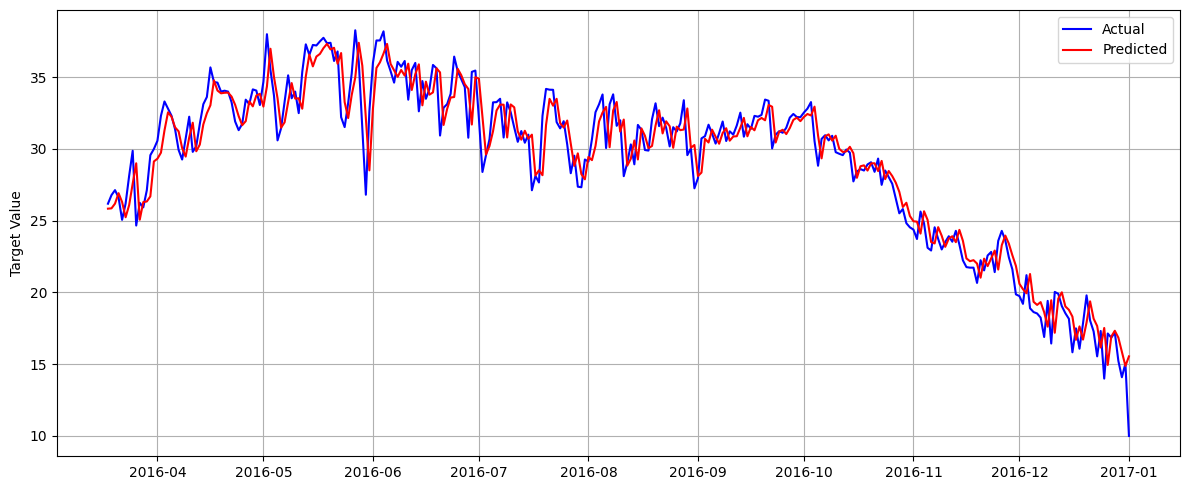

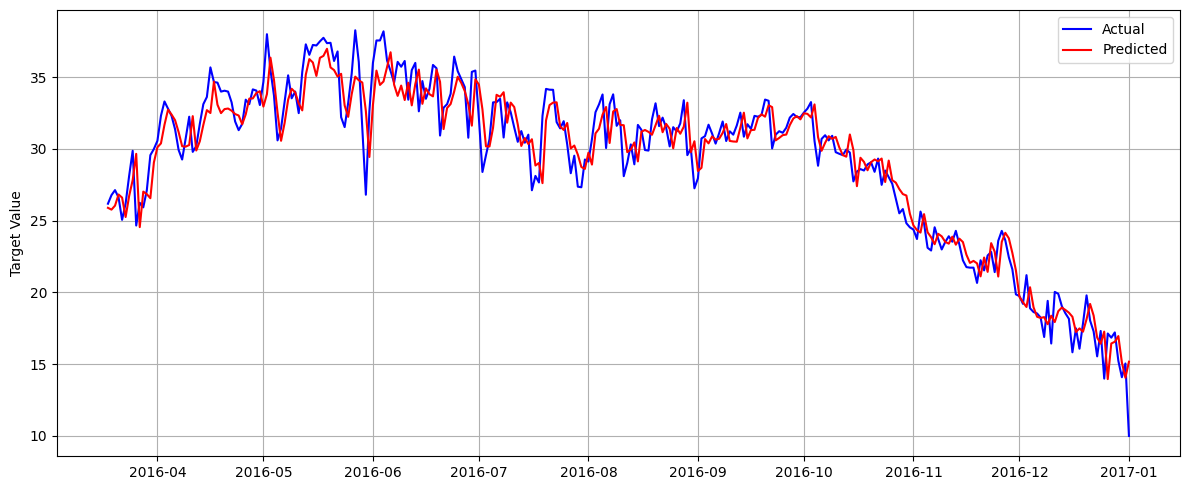

In [ ]:
plot_best_model_predictions(best_linear, x_label='Ngày', y_label='Nhiệt độ trung bình')
plot_best_model_predictions(best_rf, x_label='Ngày', y_label='Nhiệt độ trung bình')
plot_best_model_predictions(best_xgb, x_label='Ngày', y_label='Nhiệt độ trung bình')